## Install and Import Required Python Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

## Load dataset

In [3]:
df = pd.read_csv("improved_disease_dataset.csv")

## Features and target

In [4]:
X = df.drop("disease", axis=1)
y = df["disease"]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Model selection 

In [6]:
model = DecisionTreeClassifier(criterion="entropy", random_state=42)
model.fit(X, y)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Collecting User Symptom Inputs

In [7]:
print("Please enter symptoms (1 = Yes, 0 = No)\n")

user_input = {}

for symptom in X.columns:
    while True:
        try:
            value = int(input(f"{symptom.replace('_',' ').title()} (1/0): "))
            if value in [0, 1]:
                user_input[symptom] = value
                break
            else:
                print("Enter only 1 or 0.")
        except ValueError:
            print("Invalid input. Enter 1 or 0.")


Please enter symptoms (1 = Yes, 0 = No)



Fever (1/0):  1
Headache (1/0):  0
Nausea (1/0):  1
Vomiting (1/0):  0
Fatigue (1/0):  1
Joint Pain (1/0):  0
Skin Rash (1/0):  1
Cough (1/0):  0
Weight Loss (1/0):  1
Yellow Eyes (1/0):  0


## Preparing User Input for Model Prediction

In [8]:
user_df = pd.DataFrame([user_input])

## Predict Disease Based on User Input

In [9]:
prediction = model.predict(user_df)

print("\nPredicted Disease:", prediction[0])



Predicted Disease: Psoriasis


In [10]:


dt_model = DecisionTreeClassifier(
    criterion="entropy",   # Information Gain
    max_depth=6,
    random_state=42
)

dt_model.fit(X_train, y_train)


,criterion,'entropy'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [11]:
y_pred = dt_model.predict(X_test)

## Model Evaluation Metrics

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.33

Confusion Matrix:
 [[4 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 7]]

Classification Report:
                                                 precision    recall  f1-score   support

                                          AIDS       0.44      0.67      0.53         6
                                          Acne       0.50      0.25      0.33         8
                           Alcoholic hepatitis       0.00      0.00      0.00         2
                                       Allergy       0.29      0.33      0.31         6
                                     Arthritis       0.00      0.00      0.00        10
                              Bronchial Asthma       0.20      0.10      0.13        10
                          Cervical spondylosis       0.25      0.29      0.27        14
                           Chronic cholestasis       0.00      0.00      0.00        14
                           

C:\Users\Nikhil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Nikhil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Nikhil\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Label Encoding and Class Imbalance Analysis

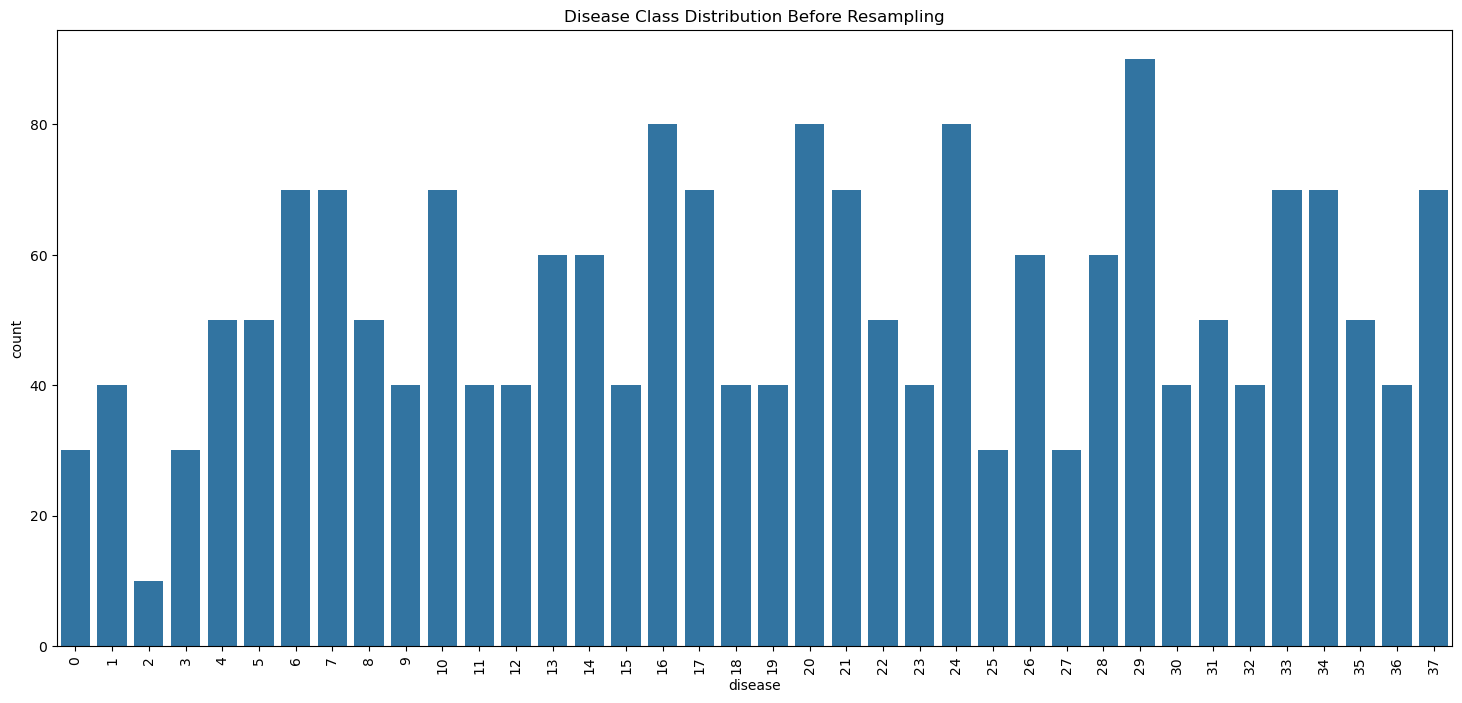

In [13]:
encoder = LabelEncoder()
df["disease"] = encoder.fit_transform(df["disease"])

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

plt.figure(figsize=(18, 8))
sns.countplot(x=y)
plt.title("Disease Class Distribution Before Resampling")
plt.xticks(rotation=90)
plt.show()

In [14]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

## Cross-Validation Based Model Evaluation

In [15]:
if 'gender' in X_resampled.columns:
    le = LabelEncoder()
    X_resampled['gender'] = le.fit_transform(X_resampled['gender'])

X_resampled = X_resampled.fillna(0)

if len(y_resampled.shape) > 1:
    y_resampled = y_resampled.values.ravel()

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

cv_scoring = 'accuracy'  # you can also use 'f1_weighted', 'roc_auc_ovr' for multi-class
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    try:
        scores = cross_val_score(
            model,
            X_resampled,
            y_resampled,
            cv=stratified_kfold,
            scoring=cv_scoring,
            n_jobs=-1,
            error_score='raise' 
        )
        print("=" * 50)
        print(f"Model: {model_name}")
        print(f"Scores: {scores}")
        print(f"Mean Accuracy: {scores.mean():.4f}")
    except Exception as e:
        print("=" * 50)
        print(f"Model: {model_name} failed with error:")
        print(e)

Model: Decision Tree
Scores: [0.5497076  0.54532164 0.53508772 0.53654971 0.52631579]
Mean Accuracy: 0.5386
Model: Random Forest
Scores: [0.56725146 0.55116959 0.53508772 0.53654971 0.5380117 ]
Mean Accuracy: 0.5456
Model: SVM
Scores: [0.51315789 0.51169591 0.49707602 0.48245614 0.49561404]
Mean Accuracy: 0.5000


## SVM Confusion Matrix and Accuracy

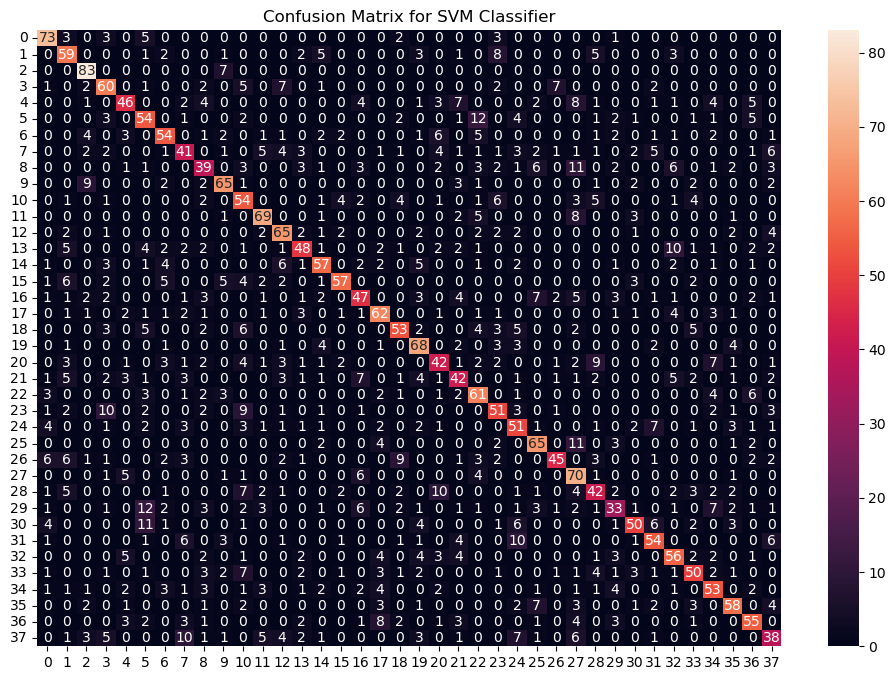

SVM Accuracy: 60.53%


In [16]:
svm_model = SVC()
svm_model.fit(X_resampled, y_resampled)
svm_preds = svm_model.predict(X_resampled)

cf_matrix_svm = confusion_matrix(y_resampled, svm_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_svm, annot=True, fmt="d")
plt.title("Confusion Matrix for SVM Classifier")
plt.show()

print(f"SVM Accuracy: {accuracy_score(y_resampled, svm_preds) * 100:.2f}%")

## Gaussian Naive Bayes Classification Results

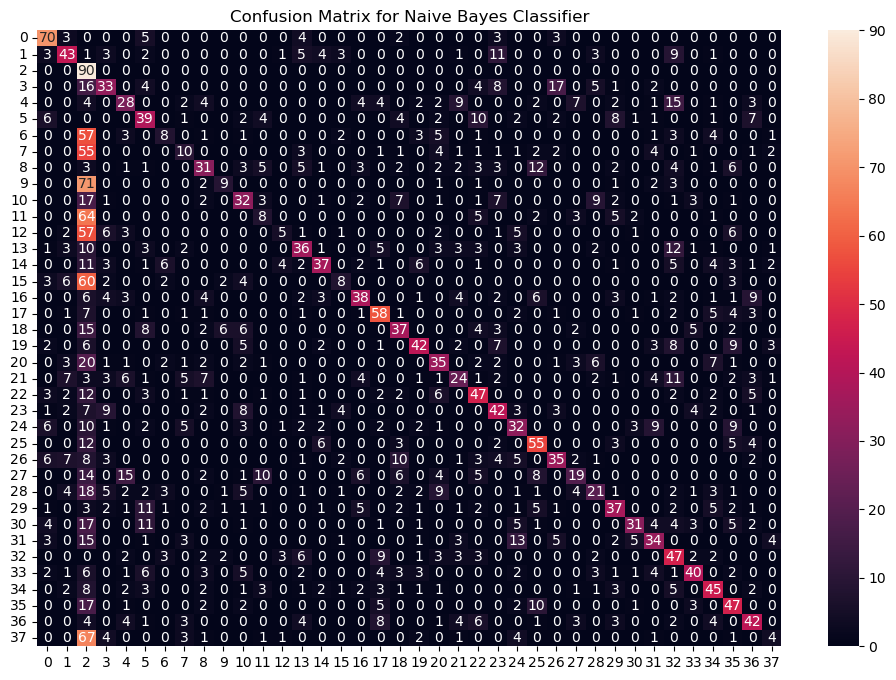

Naive Bayes Accuracy: 37.98%


In [17]:
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
nb_preds = nb_model.predict(X_resampled)

cf_matrix_nb = confusion_matrix(y_resampled, nb_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix_nb, annot=True, fmt="d")
plt.title("Confusion Matrix for Naive Bayes Classifier")
plt.show()

print(f"Naive Bayes Accuracy: {accuracy_score(y_resampled, nb_preds) * 100:.2f}%")